(ch9:anomaly)=
# Anomaly Detection For Timeseries of Networks

There is a particular type of sea slug which has gills on the outside of its body. When you squirt water at these gills, they withdraw into the slug. The interesting thing about this type of slug is that the brain network involved in this gill withdrawal reflex is entirely mapped out, from the neurons which detect and transmit information about the water into the slug's brain, to the neurons that leave the brain and fire at its muscles. (For those interested, this is a real thing - look up Eric Kandel's research on Aplysia!)

Say you're a researcher studying these sea slugs, and you have a bunch of brain networks of the same slug. We can define each node as a single neuron, and edges denote connections between neurons. Each of the brain networks that you have were taken at different time points: some before water started getting squirted at the slug's gills, and some as the water was getting squirted. Your goal is to reconstruct when water started to get squirted, using only the networks themselves. You hypothesize that there should be some signal change in your networks which can tell you the particular time at which water started getting squirted. Given the network data you have, how do you figure out which timepoints these are?

The broader class of problems this question addresses is called *anomaly detection*. The idea, in general, is that you have a bunch of snapshots of the same network over time. Although the nodes are the same, the edges are changing at each time point. Your goal is to figure out which time points correspond to the most change, either in the entire network or in particular groups of nodes. You can think of a network as "anomalous" with respect to time if some potentially small group of nodes within the network concurrently changes behavior at some point in time compared to the recent past, while the remaining nodes continue with whatever noisy, normal behavior they had.

In particular, what we would really like to do is separate the signal from the noise. All of the nodes in the network are likely changing a bit over time, since there is some variability intrinsic in the system. Random noise might just dictate that some edges get randomly deleted and some get randomly created at each step. We want to figure out if there are timepoints where the change isn't just random noise: we're trying to figure out a point in time where the probability distribution that the network *itself* is generated from changes.

Let's simulate some network timeseries data so that we can explore anomaly detection more thoroughly.

## Simulating Network Timeseries Data

For this example, we're going to assume that our sea slug brain is measured for at $12$ points in time. Each network has $100$ nodes, and for each time point, each node has a latent position. The non-anomalous time points (ten of the time points) will have the same latent positions, and the anomalous time points between $t=6$ and $t=8$ will have different latent positions.

To make the ten non-anomalous timepoints, we'll:
1. Generate 100 latent positions. Each latent position $x_i^{(N)}$ will be a (uniformly) random number between 0.2 and 0.8, for $i$ from $1$ to $100$.
2. Use `graspologic`'s `rdpg` to sample an adjacency matrix using the one-dimensional latent position matrix, $X^{(N)}_t$, whose rows are the latent positions $x_i^{(N)}$. Do this ten times, to generate the networks with adjacency matrices $A^{(t)}$, where $t$ is between $1$ and $12$ and excluding $6$ through $8$.

And to make the two perturbed time points, we'll do the following twice:
1. The first $20$ latent positions will be uniform random numbers between $0.6$ and $1.0$. These latent positions will be denoted $x_i^{(A,t)}$ respectively. The remaining $80$ latent positions will be the same for all nodes as they were for the non-anomalous timepoints, $x_i^{(N)}$.
2. Use `graspologic`'s `rdpg` to sample an adjacency matrix using the one-dimensional latent position matrix, $X_t^{(A, t)}$, whose first twenty rows are the latent positions $x_i^{(A, t)}$ and whose remaining $80$ rows are the latent positions $x_i^{(N)}$. This generates the anomalous networks with adjacency matrices $A^{(t)}$, which have different latent positions from the non-anomalous networks.

Once we have this simulated data, we'll move into some discussion about how we'll approach detecting the anomalous time points.

Below is code for generating the data. We define a function to generate a particular time-point, with an argument which toggles whether we'll perturb latent positions for that time point. Then, we just loop through our time-points to sample an adjacency matrix for each one.

In [13]:
import numpy as np
from graspologic.simulations import rdpg
    
T = 12  # number of timepoints
n = 100  # number of nodes
# non-anomalous latent positions
X = np.random.uniform(.2, .8, size=(nodes, 1))
# array of latent positions for each time point
Xts = []
for time in range(T):
    if time > 4 and time < 7:
        Xt = np.copy(X)
        Xt[0:20,:] = np.random.uniform(.6, 1.0, size=(20, 1))
        Xts.append(Xt)
    else:
        Xts.append(X)
networks = [rdpg(X) for X in Xts]

networks = np.array(networks)

You can see the adjacency matrices we generated below. Note that you can't really distinguish a difference between the ten non-anomylous time points and the two perturbed time points with the naked eye, even though the difference is there, so it would be pretty difficult to manually mark the time points - and if you have many time points, rather than just a few, you'd want to be able to automate the process.

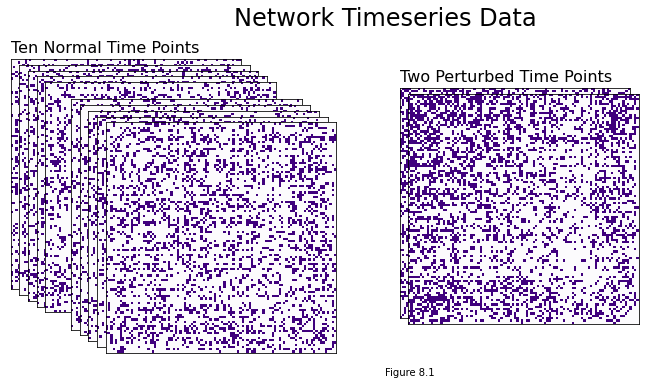

In [14]:
import matplotlib.pyplot as plt
from graphbook_code import heatmap, cmaps
import seaborn as sns

def rm_ticks(ax, x=False, y=False, **kwargs):
    if x is not None:
        ax.axes.xaxis.set_visible(x)
    if y is not None:
        ax.axes.yaxis.set_visible(y)
    sns.despine(ax=ax, **kwargs)

fig = plt.figure();

# adjacency matrices
perturbed_points = {5, 6}
for i in range(time_points):
    if i not in perturbed_points:
        ax = fig.add_axes([.02*i, -.02*i, .8, .8])
    else:
        ax = fig.add_axes([.02*i+.8, -.02*i, .8, .8])
    ax = heatmap(networks[i], ax=ax, cbar=False)
    if i == 0:
        ax.set_title("Ten Normal Time Points", loc="left", fontsize=16)
    if i == 5:
        ax.set_title("Two Perturbed Time Points", loc="left", fontsize=16)
    rm_ticks(ax, top=False, right=False)
    
plt.figtext(1, -.3, "Figure 8.1")
fig.suptitle("Network Timeseries Data", fontsize=24, x=1);

## Approaches for Anomaly Detection

It's time to start thinking about how we'd approach figuring out which of the time points are anomalies. 

One of the simplest approaches to this problem might just be to figure out which node has the highest count of edge changes across your timeseries. For each node across the timeseries, you'd count the number of new edges that appeared (compared to the previous point in time), and the number of existing edges that were deleted. Whichever count is highest could be your anomalous node.

This might give you a rough estimate -- and you could even potentially find perturbed time points with this approach -- but it's not necessarily the best solution. Counting edges doesn't account for other important pieces of information: for instance, you might be interested in which other nodes new edges were formed with. It seems like deleting or creating edges with more important nodes, for instance, should be weighted higher than deleting or creating edges with unimportant nodes.

So let's try another method. You might actually be able to guess it! The idea will be to simply estimate each network's latent positions, followed by a hypothesis testing approach. Here's the idea.

Let's call the latent positions for our network $X^{(t)}$ for the snapshot of the network at time $t$. You're trying to find specific time points, $X^{(i)}$, which are different from their previous time point $X^{(i-1)}$. Here, we're going to define "different" as the *spectral norm of the difference*, which is the largest singular value of $X^{(t)}$ and $X^{(t - 1)}$. This is denoted by the quantity $||X^{(t)} - X^{(t - 1)}||_2$, which is the $2$-norm of the matrix.

This quantity will be relatively big if $X^{(t)}$ and $X^{(t-1)}$ are not very similar, and relatively small if $X^{(t)}$ and $X^{(t-1)}$ are more similar, because it is summing the squared differences between all of the entries of $X^{(t)}$ and $X^{(t - 1)}$.

In other words, We're trying to find the time points where the difference in norm between the latent positions at time $t$ and the latent positions at time $t-1$ is *relatively* large. The idea is that non-anomalous time points (where the latent position matrices are the same) will have a difference of zero, but anomalous time points (where the latent position matrices are not the same) will have a difference which exceeds zero. 

There's an alternate problem where you restrict your view to *subsets of nodes* rather than entire adjacency matrices. The idea is that you'd find time-points which are anomalous for particular nodes or groups of nodes, rather than the entire network. The general idea is the same: you find latent positions, then test for how big the difference is between time point $t$ and time point $t-1$. This time, however, your test is for particular nodes. We'll be focusing on the problem for whole networks, but you can take a look at the original paper if you're curious about how to apply it to nodes.

### Challenges of anomaly detection

In practice, however, this is a bit more challenging than just looking for the consecutive time points with differences that exceed zero. Even in a perfect environment, such as under simulation, we run across two variations of problems that we have seen before. To perform timeseries anomaly detection, what you are first going to assume is that each network $A^{(t)}$ you observe is a sample of an [RDPG](ch5:rdpg) with a latent position matrix $X^{(t)}$, for all timepoints $t$ from $1$ to $T$. Further, we assume that the latent dimensionality $d$ is known to be the same across all of the networks. 

For each timepoint, we have the following question of interest: are the latent positions equal; that is, $H_0^{(t)} : X^{(t)} = X^{(t - 1)}W$, for some rotation matrix $W$? Or are the latent positions different; that is, $H_A^{(t)} : X^{(t)} \neq X^{(t - 1)}W$?

#### The nonidentifiability problem

When you observe the network $A^{(t)}$, you only observe the network itself: not the underlying latent position matrix $X^{(t)}$. Instead, you estimate the latent position matrix, $\hat X^{(t)}$, using [spectral embeddings](ch6:spectral). Unfortunately, latent position matrices are rotationally non-identifiable: that is, you cannot identify one latent position matrix $X^{(t)}$ from another latent position matrix $Y^{(t)} = X^{(t)}W$ where $W$ is a rotation, and the same goes for estimates of these quantities $\hat Y{(t)}$ and $\hat X^{(t)}$ as well. This means that you will need a strategy which "rotates" all of the latent position estimates into the same space. To overcome this hurdle, we need an approach which takes networks, and produces latent position estimates for each network which are rotationally aligned. Fortunately, you already know how to do this: you can use the [OMNI embedding](ch6:multinet:omni). Once your estimates are all aligned in the same latent space, you can ignore the rotation matrix, $W$, for all practical purposes for the remainder of this section.

#### We only get to obtain estimates of latent positions

Now that you have latent position estimates for each network $\hat X^{(t)}$ that are all rotated into the same space, you are presented with a new problem: the latent position estimates still won't equal the true, underlying latent positions $X^{(t)}$. This means that even if $X^{(t)} = X^{(t - 1)}$, and you are able to orient $\hat X^{(t)}$ and $X^{(t - 1)}$ so that they are rotationally aligned, your estimates *still* won't be equal. Remember these quantities are only *estimates* of latent positions, which means they will be subject to random noise *even if* the underlying true latent positions are exactly equal. That means that we aren't going to be able to just check whether two time points have a *Frobenius difference* that differs from zero; rather, we're going to need to figure out what *relatively large* and *relatively small* amount to in the context of our sample. 

## Detecting if the First Time Point is an Anomaly

We'll start with the first time point, which (because we generated the data!) we know in advance is not an anomaly.

So, here's what's going on in the code below:
1. We embed the networks $\{A^{(1)}, ..., A^{(T)}\}$ using [OMNI embedding](ch6:multinet:omni), to produce estimates of the latent position matrices $\{X^{(1)}, ..., X^{(T)}\}$ for all timepoints $t$, oriented in the same latent space.
2. We compute the norm of the difference between each pair of samples, letting $s^{(t)} = ||\hat X^{(t)} - \hat X^{(t - 1)}||_2$ with `numpy`, for the timepoint $t$. We repeat this for all timepoints except for the first timepoint, so $t$ goes from $2$ to $T$. With $T=12$ timepoints in our example, this means that we have $11$ total test statistics.

An important point to clarify is that there are a lot of different types of matrix norms: Frobenius norm, spectral norm, and so on. In our case, we'll be using the $l_2$ operator norm, which is simply the largest singular value of the matrix. The `ord` parameter argument in numpy determines which norm we use, and `ord=2` is the operator norm. 

Again, this norm, intuitively, will tell us how different two matrices are. If the norm of the difference between the true latent positions $X - Y$ is small, then $X$ and $Y$ are very similar matrices; whereas if the norm of $X - Y$ is large, then $X$ and $Y$ are very different. The norm should be large for anomalies, and small for everything else.

In [66]:
from graspologic.embed import OmnibusEmbed as OMNI

def compute_statistic(X, Y):
    """
    A function which computes the test statistic, the 2-norm.
    """
    return np.linalg.norm(X - Y, ord=2)

d = 1
# embed the networks with OMNI embedding
latents = OMNI(n_components=d).fit_transform(networks)

stat_observed = compute_statistic(latents[0], latents[1])

In [67]:
print(f'{yhat:.3f}')

0.565


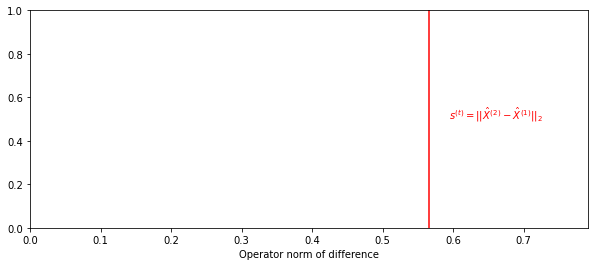

In [68]:
from matplotlib import pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.set_title("")
ax.set_ylabel("")
ax.axvline(stat_observed, color="red")
ax.text(1.05*stat_observed , .5, "$s^{(t)} = ||\\hat X^{(2)} - \\hat X^{(1)}||_2$", color="red");
ax.set_xlim([0, 1.4*stat_observed])
ax.set_xlabel("Operator norm of difference");

## Hypothesis Testing With our Test Statistic

We observe the test statistic shown with the red line above, which has a value of {glue:}`yhat`. If the first two adjacency matrices have the same latent positions, we would hope that their latent position estimates (after adjusting for rotations) are reasonably similar and the statistic would be relatively small. On the other hand, if their latent positions are different, we would hope that their latent position estimates (even after adjusting for rotations) would be reasonably large and the statistic would also be relatively large. However, the word *relative* is the key word here: *relative* what? how should we determine whether it's small enough to say that $X^{(t)}$ and $X^{(t - 1)}$ come from the same distribution, and aren't anomalalous time points?

Well, what if we could use our estimated latent positions $\hat{X}^{(t)}$ at time $t$ to generate networks, then make test statistics from those new networks? We'd know for a fact that any pair of those networks are drawn from the same set of latent positions, and we could get a sense for what our test statistic should look like if the latent positions actually were the same. 

Back in [two sample testing](ch8:twosample), we came across this same fundamental problem when attempting to determine whether two latent position matrices were identical, and here we're going to resort to virtually the same strategy: the parametric bootstrap. 

### Generating the null distribution of each pair of timepoints using the parametric bootstrap

So: recall, our original question was to determine whether $H_0^{(t)} : X^{(t)} = X^{(t - 1)}W$ or $H_A^{(t)} : X^{(t)} \neq X^{(t - 1)}W$, or that the latent positions are equal/unequal up to a rotation. This is clearly a two-sample test, so how could we adapt the approach we used in [two-sample testing](ch8:twosample) here?

Our approach is going to be as follows. Given a pair of (already-aligned) estimated latent position matrices $\hat X^{(t)}$ and $\hat X^{(t - 1)}$, for a given repetition $r$:
1. Generate two pairs of adjacency matrices, $A^{(t,2,r)}$ and $A^{(t, 1, r)}$ by sampling independently from an RDPG with latent position matrix $\hat X^{(t)}$, and the pair $A^{(t - 1, 2,r)}$ and $A^{(t - 1, 1, r)}$ by sampling independently from an RDPG with latent position matrix $\hat X^{(t - 1)}$. Notice that each pair of adjacency matrices have an identical underlying latent position matrix, which is the estimate of the latent position matrix we previously produced with OMNI.
  + For each pair of adjacency matrices for timepoint $t'$ (which can be either $t$ or $t - 1$), embed the adjacency matrices into $d$ dimensions using the OMNI embedding, to produce estimates of the latent positions $\hat X^{(t', 2, r)}$ and $\hat X^{(t', 1, r)}$.
  + Compute the corresponding statistics for each timepoint $t'$, $s^{(t')}_r = ||\hat X^{(t', 2, r)} - \hat X^{(t', 1, r)}||_2$, again using `numpy`. 

So, what's going on here exactly?

For the timepoint of interest $t$, what we are doing is effectively *using* the estimated latent position matrix $\hat X^{(t)}$ to generate new adjacency matrices (which actually *do* have the same underlying latent position matrix; namely, $\hat X^{(t)}$). Then, we embed these two adjacency matrices to obtain two *more* estimated latent position matrices,  $\hat X^{(t', 1, r)}$ and $\hat X^{(t', 0, r)}$. Let's see how this looks in code:

In [37]:
def generate_replicate(X, d=d):
    """
    Generates two estimated latent position matrices which have the same
    underlying latent position matrix, X.
    """
    A2 = rdpg(X)
    A1 = rdpg(X)
    latents = OMNI(n_components=d).fit_transform([A2, A1])
    return latents[0], latents[1]

Since these are estimates of latent position matrices from *samples* of random graphs (which are RDPGs), they won't be identical, and are in fact, quite useful: they give us an idea of just how much, if the underlying latent position matrix is the same, that the two latent position matrices will differ in terms of the statistic $s^{(t)}$! Then, we just repeat this procedure for the proceeding time point as well, since we want to use information from *all* of our networks relevant to the current timepoint: both $\hat X^{(t)}$ and $\hat X^{(t - 1)}$. 

Finally, we aggregate together all of the statistics we computed, giving us a collection of $2 \times R$ total statistics of interest. These statistics give us a sense of just how large (or small) we would expect the operator norm for our system to be *if* the underlying latent position matrices were identical. Let's see how we code this all up:

In [49]:
def compute_null_statistics(X1, X2, R=1000,d=d):
    """
    Compute the test statistics under the null for two latent position
    matrices, X1 and X2.
    """
    s = []
    for r in range(R):
        for X in [X1, X2]:
            Xrep2, Xrep1 = generate_replicate(X, d=d)
            s.append(compute_statistic(Xrep2, Xrep1))
    return np.array(s)

null_stats = compute_null_statistics(latents[1], latents[0])

Finally, we'll do exactly what we did in [two sample testing](ch8:twosample): we'll compare the statistic we obtained directly from our data, $s^{(t)}$, to all of these *null replicates*. These are called *null replicates* because they give us a sense of the magnitude of the test statistic *if* the null hypothesis were true: they indicate the behavior 
of the test statistic for two networks which have an identical underlying latent position matrix. 

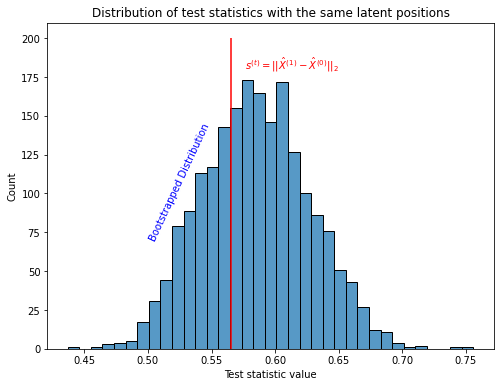

In [50]:
fig, ax = plt.subplots(figsize=(8, 6))

plot = sns.histplot(null_stats, ax=ax)
plot.set_title("Distribution of test statistics with the same latent positions");
plot.set_xlabel("Test statistic value");

plot.vlines(yhat, 0, 200, colors='r')
ax.text(1.02*stat_observed , 180, "$s^{(t)} = ||\\hat X^{(2)} - \\hat X^{(1)}||_2$", color="red");
plot.text(.50, 70, "Bootstrapped Distribution", color="blue", rotation=65);

Fortunately, {glue:}`yhat` looks like it's within a reasonable range under the assumption that the time-points share latent positions. 

### Estimating the $p$-value using the bootstrapped samples

We'll again use this observation to determine a $p$-value: the $p$-value will be the fraction of times that $s^{(t)}$ was less extreme (smaller) than an difference between two estimated latent position matrices that had the *same* underlying latent position matrix. That is, we will measure how many times $s^{(t)}$ is smaller than $s^{(t)}_r$, for all of our null statistics $s^{(t)}_r$. Remember that with $R$ replicates, this means that we will have, for a timestep $t$:
\begin{align*}
    p^{(t)} &= \frac{\text{number of times that $s^{(t)}$ is smaller than $s^{(t)}_r$} + 1}{R \times 2 + 1}
\end{align*}
Just like we did for [two-sample testing](ch8:twosample), we add a $1$ to the numerator (and denominator) since we already saw a test statistic at least as large as $s^{(t)}$: $s^{(t)}$ itself. We can do this as follows:

In [54]:
def distn_test_anomaly(X1, X2, d=d, R=1000):
    """
    Performs an anomaly distribution test.
    """
    tstat = compute_statistic(X1, X2)
    null_stats = compute_null_statistics(X1, X2, d=d, R=R)
    pval = ((null_stats >= tstat).sum() + 1)/(len(null_stats) + 1)
    return tstat, pval

tstat, pval = distn_test_anomaly(latents[1], latents[0])

In [55]:
print("Test statistic: {:3f}, p-value: {:3f}".format(tstat, pval))

Test statistic: 0.565390, p-value: 0.672164


When we use a decision threshold of $\alpha = 0.05$, our results here would indicate that we fail to reject the null hypothesis that the two timepoints ($1$ and $0$) have the same latent position matrix. In the context of the simulation we constructed, this is accurate: we *know* that timepoints $1$ and $0$ had the same latent position matrix, so this is great news! 

What happens at the true anomalous timepoints, timepoints $5$ through $7$? Let's repeat this procedure on all pairs of adjacent network timepoints and take a look:

In [60]:
pvals = {}
for t in range(2, T):
    _, pval = distn_test_anomaly(latents[t], latents[t - 1])
    pvals[f"{t}:{t+1}"] = pval

Again, since we performed multiple comparisons, we adjust the $p$-values using [Bonferroni-Holm adjustment](ch7:modelselect:multitest):

In [72]:
from statsmodels.stats.multitest import multipletests

alpha = 0.05
_, adj_pvals, _, _ = multipletests([float(p) for p in pvals.values()], alpha=alpha, method="holm")

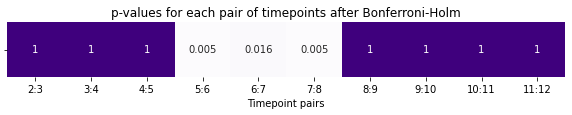

In [73]:
from graphbook_code import cmaps

data = np.fromiter(adj_pvals, dtype=float)
fig, ax = plt.subplots(figsize=(10, 1))
plot = sns.heatmap(data[:, None].T, cmap=cmaps["sequential"], 
                   cbar=False, annot=True, vmin=0, vmax=1);
plot.set_title("p-values for each pair of timepoints after Bonferroni-Holm");
plot.axes.yaxis.set_ticklabels([]);
plot.axes.xaxis.set_ticklabels(list(pvals.keys()));
plot.set_xlabel("Timepoint pairs");

Our results are consistent with what we would expect based on how the simulation was generated. 

The first $5$ timepoints all have the same underlying latent position matrix, and when we perform our statistical inference for each pair of adjacenct points in this range, we fail to reject the null hypothesis that the latent position matrix underlying the pair of adjacenct time points is the same. 

However, the $6$ and $7$ timepoints have anomalous latent positions, and the $p$-value is small for all timepoints adjacent these two times. Therefore, we have evidence to reject the null hypothesis in favor of the alternative hypothesis that the latent position matrices are different. 

Finally, when we get back to the $8$ through $12$ timepoint, again the underlying latent positions were the same, and our statistical inference would suggest that we should not reject the null hypothesis.

## The Distribution of the Bootstrapped Test Statistic

One issue that could pop up is that the bootstrapped test statistic is slightly biased. Since we're generating it from an estimate $\hat{X}$ of the true latent positions $X$, we'll have a bias of $|\hat{X} - X|$. It's worth comparing the two distributions to determine if that bias is a big deal in practice.

Below you can see the true distribution of the test statistic for the real, unperturbed set of latent positions $X$ we generated the data from (that's the blue distribution). You can also see a distribution of test statistics bootstrapped from a $\hat{X}$. You can see that in this case, they're fairly close.

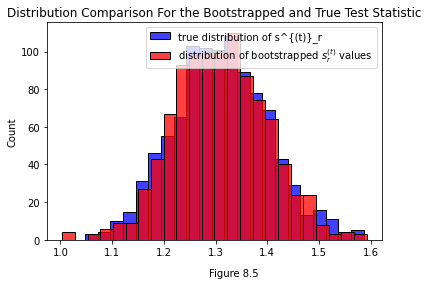

In [74]:
from graspologic.simulations import rdpg
import numpy as np
from graspologic.embed import OmnibusEmbed as OMNI

X = np.random.uniform(.2, .8, size=(100, 1))
networks = []
networks.append(rdpg(X))
networks.append(rdpg(X))

def get_statistic(adjacencies, return_latents=False):
    """
    Get the operator norm of the difference of two matrices.
    """
    omni = OMNI(n_components=2)
    latents_est = omni.fit_transform(adjacencies)
    X, Y = latents_est[0], latents_est[1]
    y = np.linalg.norm(X - Y, ord=2)
    if return_latents:
        return y, X
    else:
        return y

omni = OMNI(n_components=1)
latents = omni.fit_transform(networks)

ys_bootstrap = []
for i in range(1000):
    A_, B_ = rdpg(latents[0]), rdpg(latents[0])
    y_ = get_statistic([A_, B_])
    ys_bootstrap.append(y_)
    
ys_true = []
for i in range(1000):
    A_, B_ = rdpg(X), rdpg(X)
    y_ = get_statistic([A_, B_])
    ys_true.append(y_)
    
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(ys_true, label="true distribution of $s^{(t)}_r$", color="blue")
sns.histplot(ys_bootstrap, label="distribution of bootstrapped $s^{(t)}_r$ values", color="red")

plt.gca().legend()

plt.figtext(.5, 0, "Figure 8.5")
plt.gca().set_title("Distribution Comparison For the Bootstrapped and True Test Statistic");